In [3]:
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np

## Loading the image

In [4]:
marsh = cv.imread('plum_raw.jpg')

In [6]:
#playing around
recolor_marsh = cv.cvtColor(marsh, cv.COLOR_BGR2RGB)   # BGR -> RGB
cv.imwrite('recolor_marsh.png', recolor_marsh) 
print (type(marsh))

<class 'numpy.ndarray'>


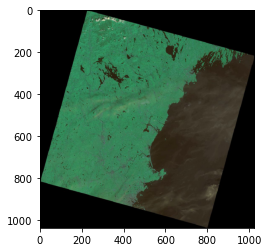

In [7]:
plt.imshow(marsh)

In [8]:
#no surprise - this has 3 channels (colors) each of which has a 1038 x 1024 array
marsh.shape

(1038, 1024, 3)

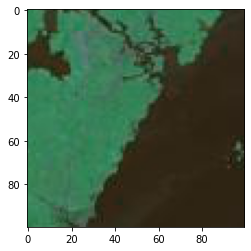

In [9]:
#zoom in on a much smaller chunk
marsh_middle = marsh[550:650,500:600,:]
plt.imshow(marsh_middle)

## Histogram 

Create a histogram for each color. We can see that there are two main spikes in red and green, probably due to differences between land and water, but blue pretty much just has one spike (or two spikes merged together). This suggests that a simple way is to just only use the red channel. 

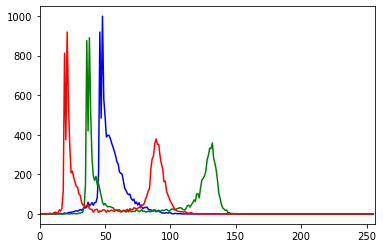

In [10]:
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv.calcHist([marsh_middle],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

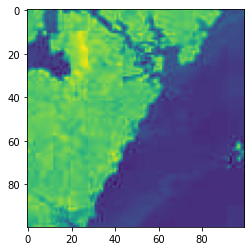

In [11]:
#we can also just plot in green, since things seem to be super well-separated there.
plt.imshow(marsh_middle[:,:,2])

## Using watershed transform to figure out the areas

In [12]:
#convert to grayscale
gray_marsh = cv.cvtColor(marsh_middle,cv.COLOR_BGR2GRAY)

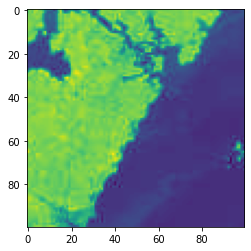

In [13]:
plt.imshow(gray_marsh)

In [18]:
ret, thresh = cv.threshold(gray_marsh,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

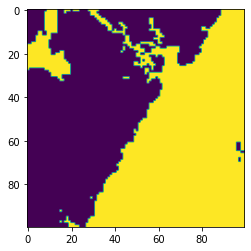

In [19]:
plt.imshow(thresh)

In [20]:
ret, markers = cv.connectedComponents(thresh)

In [21]:
#define 

markers = cv.watershed(marsh_middle,markers)
marsh_middle[markers == -1] = [255,0,0]

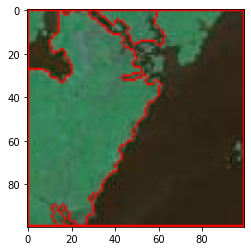

In [22]:
plt.imshow(marsh_middle)
#you can see that it's far from perfect - but pretty cool for something out of the box!

## Scratchwork

In [ ]:
print(type(thresh))

In [ ]:
thresh.shape

In [ ]:
conts,hier = cv.findContours(thresh, 1,1)

In [ ]:
m = len(conts)
for i in range(m):
    for j in range(conts[i].shape[0]):
            #print(conts[i][j,0,0],conts[i][j,0,1])
            marsh_middle[conts[i][j,0,0],conts[i][j,0,1]] = [255*i/m,0,0]
plt.imshow(marsh_middle)

In [ ]:
conts[1].shape

In [ ]:
conts[1][10,0,0]

In [ ]:
marsh_middle[20,20]

In [ ]:
len(conts)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


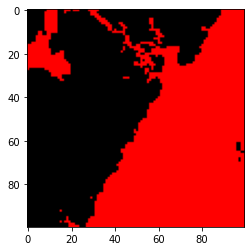

In [17]:
#make thresh into 3 channel image again 
thresh_3chan = np.zeros([100,100,3])
thresh_3chan[:,:,0] = thresh

thresh_3chan.shape
plt.imshow(thresh_3chan)